# Analysis of Text Matching Data Generated from JSTOR Dataset 

In [1]:
import pandas as pd
import numpy as np
#import spacy
import re
import json
import altair as alt
#new viz library for single-column heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

In [2]:
with open('../middlemarch.txt') as f: 
    mm = f.read()

In [3]:
textALength = len(mm) 

In [4]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [5]:
# Get book locations
bookLocations = [match.start() for match in re.finditer('\nBOOK', mm)]
bookLocations = [0] + bookLocations + [textALength] # Add one to account for last chunk.
bookLocations

[0, 3054, 250307, 481579, 681858, 915901, 1138247, 1364956, 1571148, 1793449]

In [6]:
def getChapters(text): 
    chapters = []
    for i, loc in enumerate(chapterLocations): 
        if i != len(chapterLocations)-1: 
            chapter = mm[loc:chapterLocations[i+1]]
            chapters.append(chapter)
    return chapters

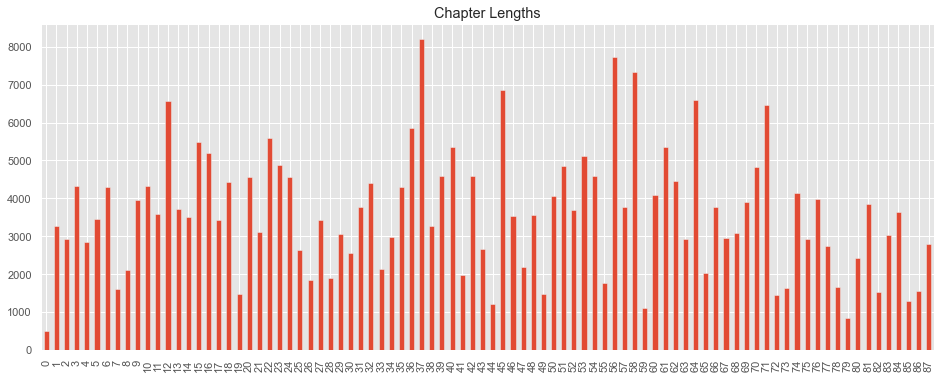

In [7]:
chapters = getChapters(mm)
chapterLengths = [len(chapter.split()) for chapter in chapters]
chapterLengthsSeries = pd.Series(chapterLengths)
chapterLengthsSeries.plot(kind='bar', title='Chapter Lengths')

In [8]:
df = pd.read_json('../data/e3.json')

In [9]:
df['Decade'] = df['year'] - (df['year'] % 10)
# df['Locations in A'] = df['matches'].apply(lambda x: x[1])
# df['NumMatches'] = df['matches'].apply(lambda x: x[0])

In [10]:
sum([len(item) for item in df['Locations in A'].values])

1794

# How many articles do we have? 

In [11]:
len(df) # Total articles with "Middlemarch" mentioned somewhere

6069

Find only those with non-trivial quotations from Middlemarch: 

In [12]:
articlesWithMatches = df[df['Locations in A'].apply(lambda x: len(x) > 0)]
articlesWithMatches.year.describe()

count     489.000000
mean     1991.871166
std        18.477106
min      1873.000000
25%      1980.000000
50%      1995.000000
75%      2007.000000
max      2016.000000
Name: year, dtype: float64

In [13]:
articlesWithMatches.Wordcounts.apply(len).head()

0    17
3     3
4     3
8     3
9    12
Name: Wordcounts, dtype: int64

In [14]:
# articlesWithMatches.to_json('../data/cleaned-matches.json')

## How many articles do we have published in each year? 

In [15]:
alt.Chart(articlesWithMatches).mark_bar().encode(x='year:O', y='count()').properties(width=1000)

alt.Chart(...)

In [16]:
df.columns

Index(['Locations in A', 'Locations in B', 'author', 'coverdate', 'disc_name',
       'doi', 'id', 'jcode', 'journal', 'la', 'no', 'numMatches', 'pages',
       'publisher_name', 'sp', 'srcHtml', 'title', 'topics', 'ty', 'vo',
       'year', 'Decade', 'Quoted Words', 'Locations in A with Wordcounts',
       'Wordcounts'],
      dtype='object')

In [17]:
df[df['Quoted Words'] > 0]['disc_name'].value_counts().head()

[Language & Literature, Humanities]                                                     201
[Language & Literature]                                                                  72
[Humanities, Language & Literature]                                                      59
[Language & Literature, History, British Studies, History, Area Studies, Humanities]     15
[Area Studies, British Studies, Humanities, Language & Literature]                        9
Name: disc_name, dtype: int64

## Find Number of Garbage Articles
I.e., articles that just contain front matter, contents, etc. 

In [18]:
def isGarbage(itemTitle): 
    badTitles = ['front matter', 'back matter', 'table of contents', 'cover']
    if itemTitle == None: 
        return False
    for title in itemTitle: 
        for badTitle in badTitles: 
            if badTitle in title.lower(): 
                return True
    return False

In [19]:
len(df[df.title.apply(isGarbage)]) # How many garbage items? 

457

# Average Numbers of Quoted Words Per Item

In [20]:
df['Quoted Words'].describe()

count    6069.000000
mean       19.240896
std       105.153455
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2498.000000
Name: Quoted Words, dtype: float64

In [21]:
articlesWithMatches['Quoted Words'].describe()

count     489.000000
mean      238.799591
std       291.466263
min        13.000000
25%        68.000000
50%       141.000000
75%       281.000000
max      2498.000000
Name: Quoted Words, dtype: float64

In [22]:
len(df[df['Quoted Words'] > 0])

489

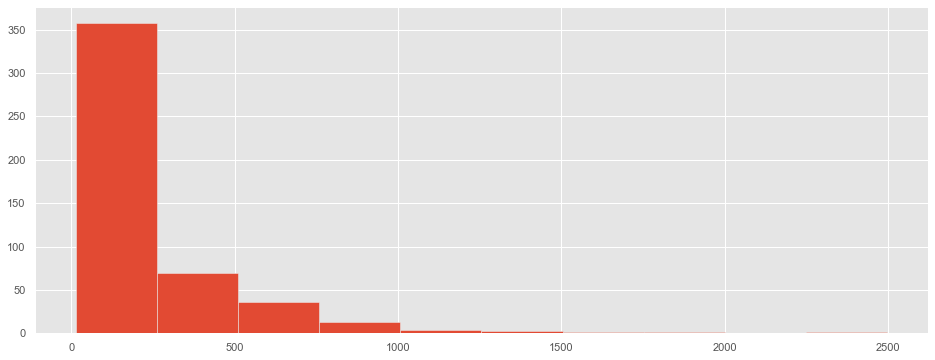

In [23]:
articlesWithMatches['Quoted Words'].hist()

## Stats about Wordcounts

Average number of words per match, per item: 

In [24]:
articlesWithMatches['Wordcounts'].apply(np.mean).head()

0     67.235294
3     23.666667
4    167.000000
8     47.333333
9     62.416667
Name: Wordcounts, dtype: float64

In [25]:
articlesWithMatches['Wordcounts'].apply(np.mean).describe()

count    489.000000
mean      69.712270
std       50.153803
min       13.000000
25%       37.000000
50%       58.500000
75%       86.000000
max      435.333333
Name: Wordcounts, dtype: float64

In [26]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations, useWordcounts=True, normalize=True):
    """ Turning on useWordcounts makes it so that it's weighted by wordcount. 
    Turning it off uses raw numbers of quotations. """
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts.copy()
        else: 
            decadeDict[decade] += locationsAndWordcounts.copy()
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    if useWordcounts: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  weights=[loc[1] for loc in locations],
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    else: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    if normalize: 
        decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    chunk = mm[locRange[0]:locRange[1]]
    return len(chunk.split())

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def extractWordcounts(locsAndWordcounts): 
    """ 
    Takes pairs of location ranges and wordcounts, 
    and returns just the wordcounts. 
    """
    return [item[1] for item in locsAndWordcounts 
            if len(locsAndWordcounts) > 0]

def synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    if useWordcounts: 
        binned = np.histogram(starts, bins=bins, 
                              weights=counts, range=(0, textALength))
    else: 
        binned = np.histogram(starts, bins=bins, 
                              range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df, save=False, reverse=False): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    if save: 
        plt.savefig('diachronic.png', bboxinches='tight', dpi=300, transparent=True)
    plt.show()
    
def plotSynchronicAnalysis(s, useWordcounts=True): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    if useWordcounts: 
        ax.set_ylabel('Number of Words Quoted')
    else: 
        ax.set_ylabel('Number of Quotations')
        
def plotSynchronicAnalysisHeatmap(s, useWordcounts=True): 
    vec1=synchronicAnalysis(df, useWordcounts=False)
    fig, ax = plt.subplots()
    sns.color_palette("magma")
    sns.heatmap([vec1])
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of Quotations')
    
def plotDiachronicAnalysisBubble(df, save=False, reverse=False):
    ylabels = [str(int(decade)) for decade in df.index] + ['2020'] 
    alt.Chart(df).mark_circle().encode(
    x='Chapter',
    y='Decade',
    size='sum(count):Q'
)

In [27]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [28]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

In [29]:
# Verify that the diachronic wordcounts are the same as the synchronic wordcounts
decadeSums = diachronicAnalysis(df, decades=(1700, 2020), useWordcounts=True, normalize=False).sum(axis=1)
decadeSums.sum()

95120.0

In [30]:
chapterSums = synchronicAnalysis(df)
chapterSums.sum()

95120

# Quotation Length Statistics

In [31]:
df['Wordcounts'] = df['Locations in A with Wordcounts'].apply(extractWordcounts)

In [32]:
wordcounts = []
for countSet in df['Wordcounts'].values: 
    for count in countSet: 
        wordcounts.append(count)

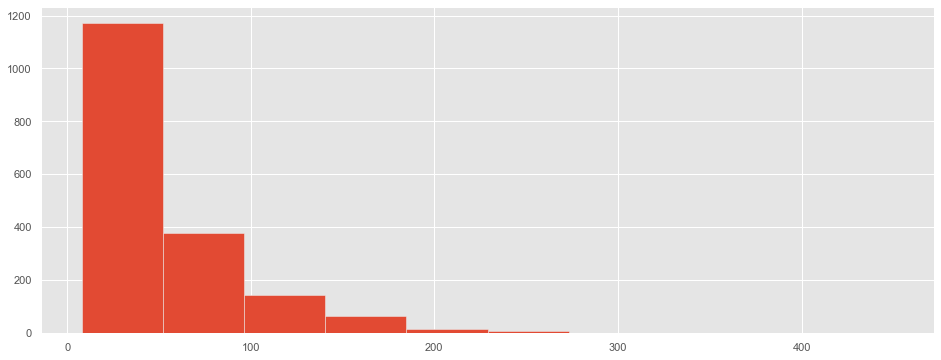

In [33]:
pd.Series(wordcounts).hist()

# Number of Quotes (and words Quoted) by Chapter

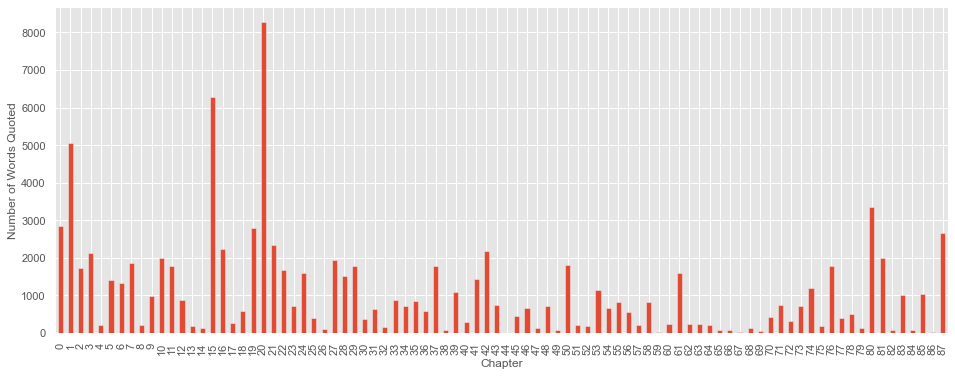

In [34]:
plotSynchronicAnalysis(synchronicAnalysis(df))

In [35]:
synchronicAnalysis(df, useWordcounts=True).to_csv('../papers/spring2017-middlemarch-paper/data/num-words-quoted-per-chapter.csv')

In [36]:
allMatches = []
for group in df['Locations in A'].values: 
    for pair in group: 
        allMatches.append(pair)

In [37]:
len(allMatches)

1794

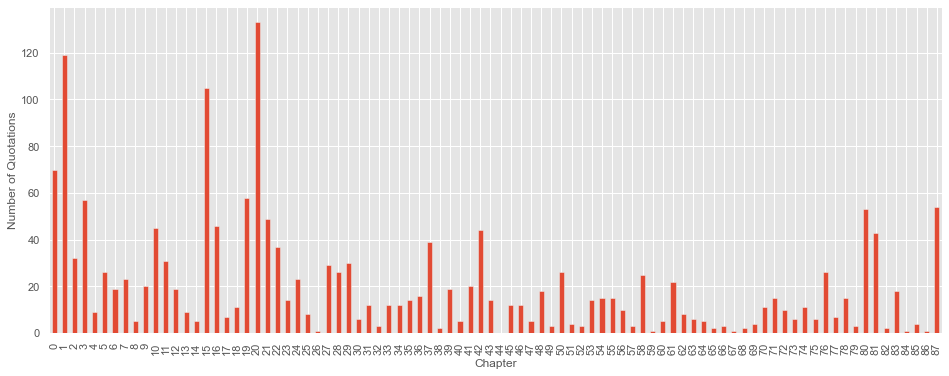

In [38]:
plotSynchronicAnalysis(synchronicAnalysis(df, useWordcounts=False), useWordcounts=False)

## Quotations Per Book

In [39]:
quotationsPerBook = synchronicAnalysis(df, bins=bookLocations, useWordcounts=False)
quotationsPerBook

0     70
1    405
2    460
3    164
4    171
5    111
6    104
7     49
8    260
dtype: int64

In [40]:
quotationsPerBook = pd.DataFrame(quotationsPerBook, index=range(0,9), columns=['# Quotations'])
quotationsPerBook['Book'] = range(0, 9)
quotationsPerBook

,# Quotations,Book
0,70,0
1,405,1
2,460,2
3,164,3
4,171,4
5,111,5
6,104,6
7,49,7
8,260,8


In [42]:
alt.Chart(quotationsPerBook).mark_bar().encode(x='Book:O', y='# Quotations:Q').properties(width=500)

alt.Chart(...)

## Raw Number of Quotations Per Chapter

In [43]:
# Get the raw number of quotations per chapter
# synchronicAnalysis(df, useWordcounts=False).to_csv('../papers/spring2017-middlemarch-paper/data/num-quotations-per-chapter.csv')

Text(0, 0.5, 'Words Quoted, Normalized')

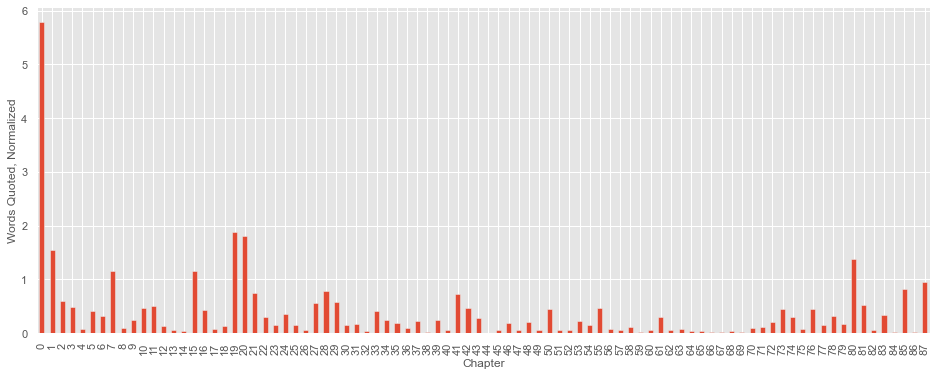

In [44]:
# Adjusted for the number of words in each chapter
ax = (synchronicAnalysis(df) / chapterLengthsSeries).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Words Quoted, Normalized')

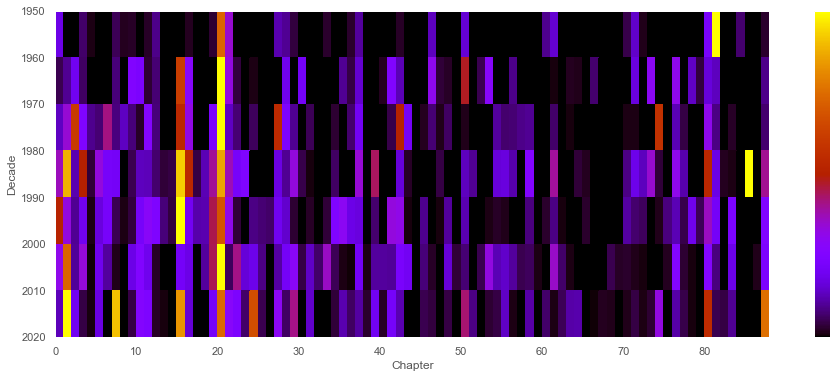

In [45]:
plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations).sort_index())

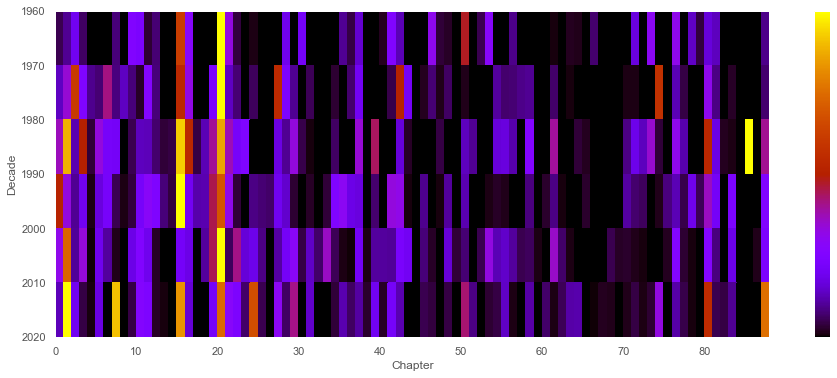

In [46]:
plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations).sort_index())

Text(120.5, 0.5, 'Number of Quotations')

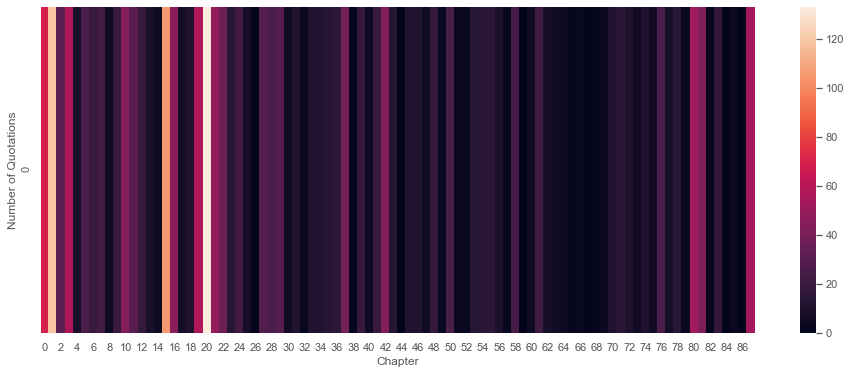

In [47]:
# Create a one-dimensional heatmap of the synchonic raw number of quotations per chapter, as heatmap
vec1=synchronicAnalysis(df, useWordcounts=False)
fig, ax = plt.subplots()
sns.color_palette("magma")
sns.heatmap([vec1])
ax.set_xlabel('Chapter')
ax.set_ylabel('Number of Quotations')

In [67]:
diaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations).sort_index()

In [49]:
plotDiachronicAnalysisBubble(diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations).sort_index())

In [69]:
synDF = synchronicAnalysis(df, useWordcounts=False)

In [72]:
synDF.index.name = 'chapter'

In [73]:
synDF

chapter
0      70
1     119
2      32
3      57
4       9
     ... 
83     18
84      1
85      4
86      1
87     54
Length: 88, dtype: int64

In [75]:
alt.Chart(synDF).mark_circle().encode(x='chapter:O', color='sum(count):Q').properties(width=1000, height=300)

SchemaValidationError: Invalid specification

        altair.vegalite.v4.api.Chart->0, validating 'additionalProperties'

        Additional properties are not allowed (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87 were unexpected)
        

alt.Chart(...)

## Redo chart in Altair

In [50]:
diaDF.columns.name = 'chapter'
diaDF.index.name = 'decade'

In [51]:
diaDF

chapter,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
decade,,,,,,,,,,,,,,,,,,,,,
1960,0.054234,0.098953,0.197907,0.064700,0.000000,0.000000,0.000000,0.081827,0.000000,0.254995,...,0.142721,0.039962,0.166508,0.134158,0.000000,0.000000,0.0,0.0,0.000000,0.093245
1970,0.138408,0.346021,0.611592,0.252595,0.096886,0.074394,0.417820,0.085640,0.137543,0.080450,...,0.000000,0.000000,0.312284,0.087370,0.000000,0.026817,0.0,0.0,0.000000,0.071799
1980,0.368069,0.884321,0.121415,0.503824,0.038241,0.334608,0.219885,0.212237,0.000000,0.051625,...,0.000000,0.000000,0.531549,0.176864,0.021989,0.014340,0.0,1.0,0.000000,0.403442
1990,0.513269,0.335404,0.099379,0.197064,0.013552,0.169396,0.219085,0.051948,0.013552,0.040655,...,0.188594,0.058159,0.364201,0.214003,0.000000,0.236589,0.0,0.0,0.000000,0.253529
2000,0.316197,0.733849,0.103276,0.340764,0.004550,0.195177,0.106460,0.016379,0.000000,0.182439,...,0.008189,0.000000,0.266606,0.082803,0.000000,0.179709,0.0,0.0,0.018198,0.237489
2010,0.131466,1.000000,0.196839,0.046695,0.008621,0.173132,0.000000,0.909483,0.000000,0.044540,...,0.010776,0.000000,0.554598,0.054598,0.043103,0.100575,0.0,0.0,0.000000,0.754310


In [52]:
diaDF.columns

RangeIndex(start=0, stop=88, step=1, name='chapter')

In [53]:
diaDF['decade'] = diaDF.index

In [54]:
diaMelted = diaDF.melt(id_vars='decade')

In [55]:
alt.Chart(diaMelted).mark_rect().encode(x='chapter:O', y='decade:O', color='value').properties(width=1000, height=300)

alt.Chart(...)

In [56]:
alt.Chart(diaMelted).mark_circle().encode(x='chapter:O', y='decade:O', size='value').properties(width=1000, height=300)

alt.Chart(...)

In [57]:
booksDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations).sort_index()
booksDiaDF

,0,1,2,3,4,5,6,7,8
1960,0.023909,0.460570,1.000000,0.184983,0.309983,0.526007,0.044463,0.122903,0.524329
1970,0.055885,1.000000,0.933636,0.405868,0.354523,0.166259,0.207125,0.014670,0.503318
1980,0.102859,0.755009,1.000000,0.257013,0.284798,0.085760,0.308576,0.092439,0.867219
1990,0.167434,0.618346,1.000000,0.220851,0.530300,0.117517,0.082151,0.069442,0.538405
2000,0.130296,0.889389,1.000000,0.688601,0.348331,0.401200,0.384327,0.058680,0.463255
2010,0.045096,1.000000,0.851651,0.590685,0.317891,0.235091,0.156727,0.117792,0.707491


In [58]:
booksDiaDF['decade'] = booksDiaDF.index

In [59]:
booksMelted = booksDiaDF.melt(id_vars='decade', var_name='book')

In [60]:
booksMelted.head()

,decade,book,value
0,1960,0,0.023909
1,1970,0,0.055885
2,1980,0,0.102859
3,1990,0,0.167434
4,2000,0,0.130296


In [61]:
alt.Chart(booksMelted).mark_rect().encode(x='book:O', y='decade:O', color='value').properties(width=500, height=300)

alt.Chart(...)

In [62]:
alt.Chart(booksMelted).mark_circle().encode(x='book:O', y='decade:O', size='value').properties(width=500, height=300)

alt.Chart(...)

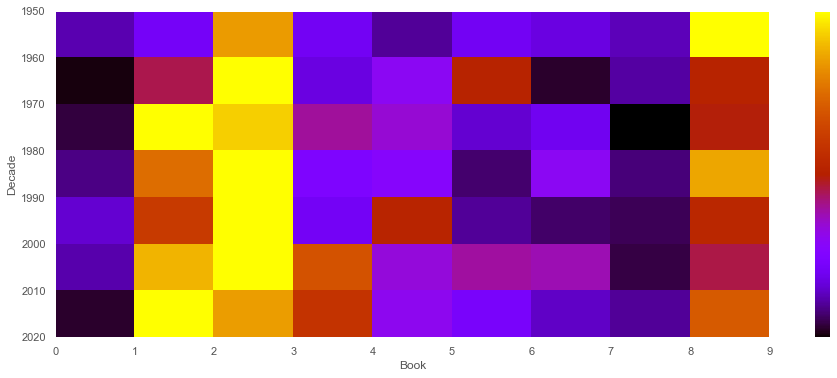

In [148]:
def plotDiachronicAnalysisBooks(df, save=False, reverse=False): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Book')
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    if save: 
        plt.savefig('diachronic.png', bboxinches='tight', dpi=300, transparent=True)
    plt.show()

plotDiachronicAnalysisBooks(diachronicAnalysis(df, decades=(1950, 2020), bins=bookLocations).sort_index())

In [149]:
# Export image for publication
# plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations), save=True)

In [150]:
# Get the normalized proportion of, say, Chapter 20 in 1950: 
diachronicAnalysis(df)[20][1950]

0.736392742796158

# By (Guessed) Gender of Author

In [151]:
maleNames, femaleNames = names.words('male.txt'), names.words('female.txt')
maleNames = [name.lower() for name in maleNames]
femaleNames = [name.lower() for name in femaleNames]

NameError: name 'names' is not defined

In [ ]:
def guessGender(name): 
    name = name.split()[0].lower() # Grab the first name. 
    if name in maleNames and name in femaleNames: 
        return 'A' #Ambiguous
    elif name in maleNames: 
        return 'M'
    elif name in femaleNames: 
        return 'F'
    else: 
        return 'U'

def averageGender(names): 
    if type(names) != list: 
        return 'U'
    genderGuesses = [guessGender(name) for name in names]
    stats = Counter(genderGuesses).most_common()
    if len(stats) == 1: 
        # Only one author. We can just use that's author's gender guess. 
        return stats[0][0]
    elif stats[0][1] == stats[1][1]: # There's a tie. 
        return 'A' # Ambiguous. 
    else: 
        return stats[0][0] # Return the most common gender. 
        

In [152]:
df['gender'] = df['author'].apply(averageGender)
dfF = df.loc[df['gender'] == 'F']
dfM = df.loc[df['gender'] == 'M']

NameError: name 'averageGender' is not defined

In [153]:
# Differences in citations between genders. 
plotSynchronicAnalysis(synchronicAnalysis(dfM) - synchronicAnalysis(dfF))

NameError: name 'dfM' is not defined

# By (Guessed) Country of Publication

In [154]:
def getFirst(row): 
    if type(row) == list: 
        return row[0]
    else: 
        return row

topPublishers = df['publisher_name'].apply(getFirst).value_counts()

In [155]:
publishers = topPublishers[:80].index

In [156]:
publishers = publishers.tolist()

In [157]:
def getCountry(publisher): 
    brits = ['Oxford University Press', 'Cambridge University Press', 'Modern Humanities Research Association', \
             'BMJ', 'Taylor & Francis, Ltd.', 'Edinburgh University Press', \
             'Royal Society for the Encouragement of Arts, Manufactures and Commerce']
    canadians = ['Victorian Studies Association of Western Canada'] 
    if type(publisher) != list: 
        return 'Unknown'
    publisher = publisher[0]
    if publisher in brits: 
        return 'Britain' 
    elif publisher in canadians or 'Canada' in publisher: 
        return 'Canada' 
    elif 'GmbH' in publisher: 
        return 'Germany'
    elif 'estudios' in publisher: 
        return 'Spain'
    elif 'France' in publisher: 
        return 'France' 
    elif 'Ireland' in publisher: 
        return 'Ireland'
    else: 
        return 'US'

In [158]:
df['country'] = df['publisher_name'].apply(getCountry)

In [159]:
df['country'].value_counts()

US         3901
Unknown    1247
Britain     825
Canada       59
Germany      15
Spain         8
Ireland       8
France        6
Name: country, dtype: int64

In [160]:
dfBrits = df.loc[df['country'] == 'Britain']
dfYanks = df.loc[df['country'] == 'US']
dfCanadians = df.loc[df['country'] == 'Canada']

In [161]:
# Since British authors are greatly outnumbered in this corpus, we should normalize the data. 
britsHist = synchronicAnalysis(dfBrits) 
normBrits = britsHist.div(britsHist.max())
yanksHist = synchronicAnalysis(dfYanks)
normYanks = yanksHist.div(yanksHist.max())

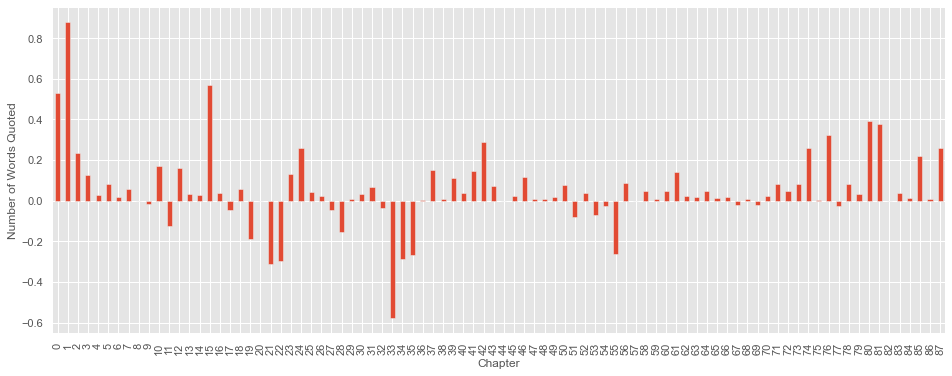

In [162]:
plotSynchronicAnalysis(normYanks - normBrits)

# By Journal

In [163]:
# Look at the top journals. 
journalStats = df['journal'].value_counts()
journalStats[:10]

Victorian Studies                            424
George Eliot - George Henry Lewes Studies    206
Nineteenth-Century Fiction                   192
The Modern Language Review                   188
The Review of English Studies                185
Nineteenth-Century Literature                126
NOVEL: A Forum on Fiction                    126
Studies in the Novel                         120
Studies in English Literature, 1500-1900      85
ELH                                           77
Name: journal, dtype: int64

In [164]:
journalList = journalStats.index

Compare the specialist journal, "George Eliot - George Henry Lewes Studies," with all other journals. 

In [165]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

In [166]:
# Normalize
geDF = synchronicAnalysis(geJournals)
otherDF = synchronicAnalysis(otherJournals)
normGE = geDF.div(geDF.max())
normOther = otherDF.div(otherDF.max())

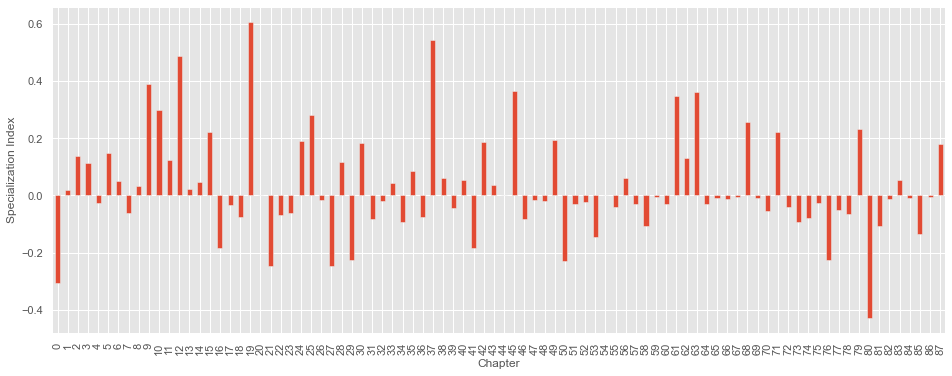

In [167]:
fig = plt.figure()
ax = (normGE - normOther).plot(kind='bar')
fig.add_subplot(ax)
ax.set_xlabel('Chapter')
ax.set_ylabel('Specialization Index')
# Save a big version for publication. 
fig.savefig('specialization.png', bboxinches='tight', dpi=300)

In [168]:
journals = pd.DataFrame({title: synchronicAnalysis(df.loc[df['journal'] == title]) for title in journalList }).T

In [169]:
cutoff = 1500
topJournals = journals.loc[journals.sum(axis=1) > cutoff]
otherJournals = journals.loc[journals.sum(axis=1) < cutoff]
topJournals.loc['Other'] = otherJournals.sum()

/Users/sierraeckert/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


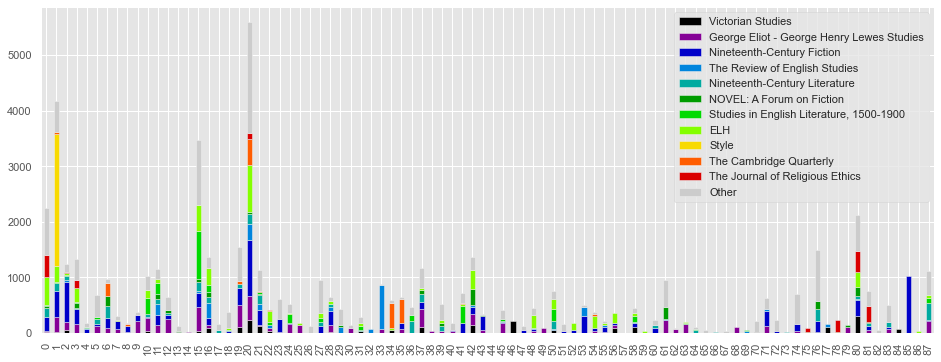

In [170]:
topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')

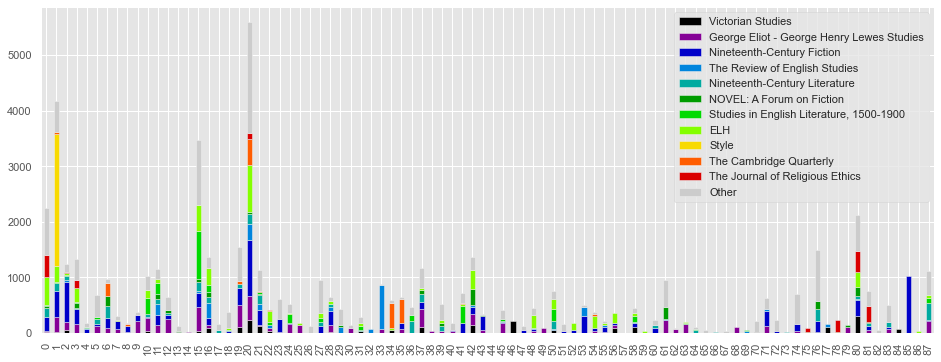

In [171]:
ax = topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')
fig = ax.get_figure()
fig.savefig('synchronic-journals.png', bboxinches='tight', dpi=300)

# Detour: Ch. 15

In [172]:
# Try to find out why Ch. 15 was so big in the 80s and 90s. 
chap15s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [2000]: 
        for start in starts: 
            if start > 290371 and start < 322052: # Does it cite Chapter XV? 
                if row.id not in ids: 
                    chap15s.append(row)
                    ids.append(row.id)

In [173]:
# Get the titles of those articles. 
[item.title for item in chap15s]

[['Is Middlemarch Ahistorical?'],
 ['A CHANGE IN THE UNITS: "MIDDLEMARCH", G. H. LEWES, AND RUDOLF VIRCHOW'],
 ['LANGUAGES OF "MATTER": ELIOT, LEWES, HUXLEY, AND THE MIND/BODY RELATIONSHIP'],
 ['Sympathy and Telepathy: The Problem of Ethics in George Eliot\'s "The Lifted Veil"'],
 ['Fiction as Vivisection: G. H. Lewes and George Eliot'],
 ['Sympathy Time: Adam Smith, George Eliot, and the Realist Novel'],
 ['THE MEDICAL GAZE AND THE FEMALE CORPSE: LOOKING AT BODIES IN MARY SHELLEY\'S "FRANKENSTEIN"']]

In [174]:
ch15Topics =  [item.topics for item in chap15s]
chap15TopicsFlat = [item for sublist in ch15Topics for item in sublist]
Counter(chap15TopicsFlat).most_common(20)

[('Sympathy', 4),
 ('Selfishness', 3),
 ('Pathos', 2),
 ('Vanity', 2),
 ('Artistic realism', 2),
 ('Compliments', 2),
 ('Sadness', 2),
 ('Udders', 2),
 ('Egotism', 2),
 ('Paranormal experiences', 2),
 ('Pity', 2),
 ('Telepathy', 2),
 ('Avowals', 2),
 ('Vivisection', 2),
 ('Melodrama', 2),
 ('Dissection', 2),
 ('Anatomy', 2),
 ('Spontaneity', 2),
 ('Hypocrisy', 2),
 ('Aristocracy', 1)]

# Chapter 20

In [175]:
Chapter 20 Detour


SyntaxError: invalid syntax (<ipython-input-175-63d115d42065>, line 1)

In [176]:
# Try to find out what articles cited chapter 20 
chap20s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 406324 and start < 432778: # Does it cite Chapter XX? 
                if row.id not in ids: 
                    chap20s.append(row)
                    ids.append(row.id)


In [177]:
# Get the titles of those articles. 
[item.title for item in chap20s]

[['Dorothea and "Miss Brooke" in Middlemarch'],
 ['The Metaphorical Imagination of George Eliot'],
 ['The Germ and the Picture in Middlemarch'],
 ['"Middlemarch," Obligation, and Dorothea\'s Duplicity'],
 ['Torpedoes, tapirs and tortoises: scientific discourse in "Middlemarch"'],
 ['“The Continuity of Married Companionship”'],
 ['Religious Humanism and the Victorian Novel: George Eliot, Walter Pater and Samuel Butler',
  'Middlemarch:',
  'The Balance of Progress'],
 ["ELIOT'S SPANISH CONNECTION: CASAUBON, THE AVATAR OF QUIXOTE"],
 ['"MIDDLEMARCH": ELIOT\'S TENDER SUBVERSION'],
 ['Middlemarch, Realism and the Birth of the Clinic'],
 ['ROME IN "MIDDLEMARCH": A NEED FOR FOREIGNNESS'],
 ['"Myriad-Headed, Myriad-Handed": Labor in "Middlemarch"'],
 ['DOROTHEA BROOKE UND EROTISCHE KUNST IN GEORGE ELIOTS "MIDDLEMARCH"'],
 ['Little Dorrit and Dorothea Brooke: Interpreting the Heroines of History'],
 ['Women, Energy, and "Middlemarch"'],
 ['Inherited Emotions: George Eliot and the Politics of H

In [178]:
articlesWithoutMatches.title #Print the titles of articles without matches


NameError: name 'articlesWithoutMatches' is not defined

In [179]:
len(chap20s)

82

In [180]:
# Try to find out what articles cite paragraph 6 in Chapter 20
chap20par6s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 411152 and start < 412177: # Does it cite Chapter XX? 
                if row.id not in ids: 
                    chap20par6s.append(row)
                    ids.append(row.id)


In [181]:
# Get the titles of those articles.
[item.title for item in chap20par6s]

[['Dorothea and "Miss Brooke" in Middlemarch'],
 ['Torpedoes, tapirs and tortoises: scientific discourse in "Middlemarch"'],
 ['“The Continuity of Married Companionship”'],
 ['"Myriad-Headed, Myriad-Handed": Labor in "Middlemarch"'],
 ['THE ECONOMIC PROBLEM OF SYMPATHY: PARABASIS, INTEREST, AND REALIST FORM IN "MIDDLEMARCH"'],
 ['Why Read George Eliot? Her novels are just modern enough—and just old-fashioned enough, too'],
 ["Tolstoj's Reading of George Eliot: Visions and Revisions"],
 ["Under Conrad's Eyes",
  'The Novel as Criticism',
  'The Trouble with Sympathy in Middlemarch and Nostromo'],
 ['Views from above and below: George Eliot and Fakir Mohan Senapati'],
 ['Sounds of Modern History',
  'Auditory Cultures in 19th- and 20th-Century Europe',
  'English Beat:',
  'The Stethoscopic Era’s Sonic Traces'],
 ['"Be Ye Lukewarm!": The Nineteenth-Century Novel and Social Action'],
 ['A Note on Middlemarch'],
 ["The Squirrel's Heartbeat: Some Thoughts on the Later Style of Henry James"]

In [182]:
len(chap20par6s) # The number of items citing paragraph 6 in chapter 20

30

In [183]:
xxStart, xxEnd = chapterLocations[20:22] # Chapter 20 Boundaries

In [184]:
print(mm[xxStart:xxStart+1000]) # Verify we have Ch. 20

CHAPTER XX.

    "A child forsaken, waking suddenly,
     Whose gaze afeard on all things round doth rove,
     And seeth only that it cannot see
     The meeting eyes of love."


Two hours later, Dorothea was seated in an inner room or boudoir of a
handsome apartment in the Via Sistina.

I am sorry to add that she was sobbing bitterly, with such abandonment
to this relief of an oppressed heart as a woman habitually controlled
by pride on her own account and thoughtfulness for others will
sometimes allow herself when she feels securely alone.  And Mr.
Casaubon was certain to remain away for some time at the Vatican.

Yet Dorothea had no distinctly shapen grievance that she could state
even to herself; and in the midst of her confused thought and passion,
the mental act that was struggling forth into clearness was a
self-accusing cry that her feeling of desolation was the fault of her
own spiritual poverty.  She had married the man of her choice, and with
the advantage over most girls t

In [185]:
xx = mm[xxStart:xxEnd]

In [186]:
xxParaLocations = [match.start() for match in re.finditer('\n\n+', mm)]
xxParaLocations = [x for x in xxParaLocations if (x > xxStart) and (x < xxEnd)] 

In [187]:
mm[xxParaLocations[4]:xxParaLocations[5]]

'\n\nBut this stupendous fragmentariness heightened the dreamlike\nstrangeness of her bridal life.  Dorothea had now been five weeks in\nRome, and in the kindly mornings when autumn and winter seemed to go\nhand in hand like a happy aged couple one of whom would presently\nsurvive in chiller loneliness, she had driven about at first with Mr.\nCasaubon, but of late chiefly with Tantripp and their experienced\ncourier.  She had been led through the best galleries, had been taken\nto the chief points of view, had been shown the grandest ruins and the\nmost glorious churches, and she had ended by oftenest choosing to drive\nout to the Campagna where she could feel alone with the earth and sky,\naway-from the oppressive masquerade of ages, in which her own life too\nseemed to become a masque with enigmatical costumes.'

In [188]:
articlesWithMatches['Locations in A'].loc[0]

[[5809, 6218],
 [8751, 9046],
 [57013, 57100],
 [83868, 83999],
 [116900, 117594],
 [192301, 192441],
 [195148, 195661],
 [402604, 402726],
 [411725, 412177],
 [449403, 450049],
 [450145, 450244],
 [1575265, 1575374],
 [1576340, 1576437],
 [1648982, 1649704],
 [1688955, 1689089],
 [1689907, 1690307],
 [1708999, 1709342]]

In [189]:
def inXX(matches): 
    """ Determine if the article has a match in Ch. 20"""
    for match in matches: 
        if match[0] > xxStart and match[0] < xxEnd:
            return True
    return False

In [190]:
articlesWithMatches['Locations in A'].apply(inXX).head()

0     True
3    False
4    False
8    False
9    False
Name: Locations in A, dtype: bool

In [191]:
def paraIndicesIn20(matches, paraLocations=xxParaLocations): 
    """ Determine paragraph number (index) for match in Ch. 20. """
    paraIndices = []
    if inXX(matches): 
        paraBoundaries = list(zip(paraLocations, paraLocations[1:]))
        for match in matches: 
            for i, paraBoundary in enumerate(paraBoundaries): 
                if set(range(match[0], match[1])) & set(range(paraBoundary[0], paraBoundary[1])): # find the set intersection of the ranges of pairs
                    paraIndices.append(i)
                else: 
                    paraIndices.append(None)
    return paraIndices
                    
                

In [192]:
len(set(range(8, 10)) & set(range(1, 9)))

1

In [193]:
articlesWithMatches['paraIndicesIn20'] = articlesWithMatches['Locations in A'].apply(paraIndicesIn20)

<ipython-input-193-88f15cdc3712>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articlesWithMatches['paraIndicesIn20'] = articlesWithMatches['Locations in A'].apply(paraIndicesIn20)


In [194]:
counters = list(articlesWithMatches['paraIndicesIn20'].apply(Counter))

In [195]:
grandTally = Counter()

In [196]:
for counter in counters: 
    grandTally += counter

In [197]:
del grandTally[None]

In [198]:
dict(grandTally)

{6: 32,
 10: 17,
 12: 1,
 15: 1,
 9: 1,
 11: 6,
 33: 5,
 5: 34,
 4: 4,
 25: 1,
 7: 6,
 17: 4,
 16: 9,
 14: 1,
 18: 3,
 26: 5,
 3: 3,
 29: 2,
 2: 1}

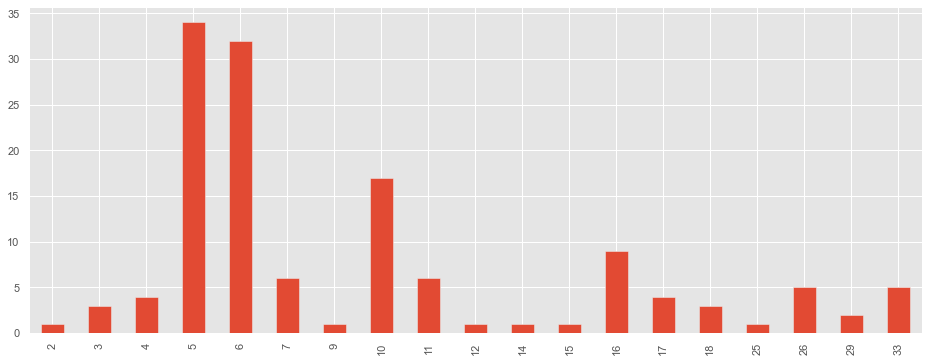

In [199]:
pd.Series(dict(grandTally)).sort_index().plot(kind='bar')

In [200]:
print(mm[xxParaLocations[5]:xxParaLocations[7]]) # What are paragraphs #5 and #6? 



To those who have looked at Rome with the quickening power of a
knowledge which breathes a growing soul into all historic shapes, and
traces out the suppressed transitions which unite all contrasts, Rome
may still be the spiritual centre and interpreter of the world.  But
let them conceive one more historical contrast: the gigantic broken
revelations of that Imperial and Papal city thrust abruptly on the
notions of a girl who had been brought up in English and Swiss
Puritanism, fed on meagre Protestant histories and on art chiefly of
the hand-screen sort; a girl whose ardent nature turned all her small
allowance of knowledge into principles, fusing her actions into their
mould, and whose quick emotions gave the most abstract things the
quality of a pleasure or a pain; a girl who had lately become a wife,
and from the enthusiastic acceptance of untried duty found herself
plunged in tumultuous preoccupation with her personal lot.  The weight
of unintelligible Rome might lie easily on b

# Nonmatches

In [201]:
df # Print the dataframe

,Locations in A,Locations in B,author,coverdate,disc_name,doi,id,jcode,journal,la,...,title,topics,ty,vo,year,Decade,Quoted Words,Locations in A with Wordcounts,Wordcounts,country
0,"[[5809, 6218], [8751, 9046], [57013, 57100], [...","[[10456, 10865], [10994, 11737], [12404, 12491...",[Harriet Farwell Adams],[19840601],"[Language & Literature, Humanities]",10.2307/3044822,c6e6ce20-79c4-3c59-af91-b06c3208b37b,[ninecentfict],Nineteenth-Century Fiction,[eng],...,"[Dorothea and ""Miss Brooke"" in Middlemarch]","[Sentiment, Fear, Martyrdom, Envy, Vocation, G...",fla,[39],1984,1980,964,"[([5809, 6218], 71), ([8751, 9046], 56), ([570...","[71, 56, 17, 26, 115, 24, 86, 15, 86, 123, 16,...",US
1,[],[],[HUGH WITEMEYER],[19910901],"[Language & Literature, Humanities]",10.2307/43470798,0d7eb58a-e4c1-326b-a195-012da1a4eb11,[georelioghlnews],"The George Eliot, George Henry Lewes Newsletter",[eng],...,None,"[Lecture methods, Feminism, Pedagogy, Novelist...",brv,None,1991,1990,0,[],[],US
2,[],[],"[Alison Cree, Louis J. Guillette, <suffix>Jr.<...",[19950601],"[Biological Sciences, Science and Mathematics,...",10.2307/1564553,f7384b7a-36be-3f0f-ac0b-b66455da0d36,[jherpetology],None,[eng],...,[Biennial Reproduction with a Fourteen-Month P...,"[Animal vivipary, Parturition, Fat body, Skink...",fla,[29],1995,1990,0,[],[],US
3,"[[1814, 1922], [1638943, 1639037], [1649154, 1...","[[23226, 23334], [25173, 25266], [27097, 27225]]",[Calvin Bedient],[19690401],"[Language & Literature, Humanities]",10.2307/3849222,ba20b1ad-b273-3608-bc9b-17b13f6d4e68,[hudsonreview],The Hudson Review,[eng],...,[Middlemarch: Touching Down],"[Immortality, Asceticism, Sentimentality, Mete...",fla,[22],1969,1960,62,"[([1814, 1922], 17), ([1638943, 1639037], 19),...","[17, 19, 26]",US
4,"[[397716, 398312], [1588815, 1589729], [158881...","[[20493, 21084], [22491, 23406], [22491, 23416]]",[Jane S. Smith],[19770701],"[Language & Literature, Humanities]",10.2307/40754482,ef12c01b-c42d-39b8-84dd-d00e6538143c,[texastudlitelang],Texas Studies in Literature and Language,[eng],...,[The Reader as Part of the Fiction: Middlemarch],"[Novels, Flattery, Humor, Vanity, Meditation, ...",fla,[19],1977,1970,413,"[([397716, 398312], 102), ([1588815, 1589729],...","[102, 155, 156]",US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,[],[],[Paul A. Brown],[19570401],"[Humanities, Language & Literature]",10.2307/2699152,2fa32cdd-0abb-37f8-ab1f-714e67c65582,[pmla],None,[eng],...,[1956 Annual Bibliography],"[Music criticism, Eurythmy, Annotated bibliogr...",mis,[72],1957,1950,0,[],[],US
6065,[],[],[Paul A. Brown],[19600501],"[Humanities, Language & Literature]",10.2307/2699365,c8f2a2ba-bf55-30e9-a744-bf9af751d955,[pmla],None,[eng],...,[1959 Annual Bibliography],"[Onomastics, Music criticism, Periodicals, Ana...",mis,[75],1960,1960,0,[],[],US
6066,[],[],[Paul A. Brown],[19590501],"[Humanities, Language & Literature]",10.2307/2699226,14b84b3e-49ed-3348-bf73-feb00bc75221,[pmla],None,[eng],...,[1958 Annual Bibliography],"[Music criticism, Bibliographies, Onomastics, ...",mis,[74],1959,1950,0,[],[],US
6067,[],[],None,"[20120101, 20120101]",[Language & Literature],10.3138/9781442662087.6,2416af8e-ce14-3993-ab70-42aa0b839b19,None,None,[eng],...,[Index to the Collected Works of Northrop Frye...,"[Myths, Satire, Catharsis, Mimesis, Masques, P...",mis,[30],2012,2010,0,[],[],Unknown


In [202]:
df[df.title.apply(isGarbage)] # How many garbage items? 

,Locations in A,Locations in B,author,coverdate,disc_name,doi,id,jcode,journal,la,...,title,topics,ty,vo,year,Decade,Quoted Words,Locations in A with Wordcounts,Wordcounts,country
278,"[[1777736, 1778104]]","[[60663, 61483]]",[Vybarr Cregan-Reid],"[20130101, 20130101]",[Language & Literature],10.2307/j.ctt18mbdzh.9,a4c64755-4651-3feb-8aaf-a6565b6735b9,None,None,[eng],...,"[Discovering Gilgamesh, Geology, narrative and...","[Narrative plot, Love, Fear, Melodrama, Metony...",mis,None,2013,2010,66,"[([1777736, 1778104], 66)]",[66],Unknown
317,[],[],[U. C. Knoepflmacher],"[19650101, 19650101]",[Language & Literature],10.2307/j.ctt13x1970.3,2991fd16-509a-33a2-b768-31e269079eef,None,None,[eng],...,[Religious Humanism and the Victorian Novel: G...,None,mis,None,1965,1960,0,[],[],Unknown
350,[],[],None,[20151101],"[Language & Literature, Humanities]",10.5325/georelioghlstud.67.2.fm,c0759c3c-1dff-3982-ae78-6e440184eaab,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],...,[Front Matter],"[Newsletters, Fair use, Advertising media, Pee...",mis,[67],2015,2010,0,[],[],US
375,[],[],None,[20150501],"[Language & Literature, Humanities]",10.5325/georelioghlstud.67.1.fm,61013785-2b6f-3124-9529-8cdc0985f016,[georelioghlstud],George Eliot - George Henry Lewes Studies,[eng],...,[Front Matter],"[Newsletters, Fair use, Advertising media, Pub...",mis,[67],2015,2010,0,[],[],US
435,[],[],None,[19681001],"[Language & Literature, Humanities]",10.2307/1344791,efc9cd8e-b2b0-3eb4-8f63-f2aadbb4bcfa,[noveforufict],NOVEL: A Forum on Fiction,[eng],...,[Front Matter],"[Book publishing, Literary criticism, Written ...",mis,[2],1968,1960,0,[],[],US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,[],[],None,[20081101],"[Humanities, Language & Literature]",10.2307/25501993,50052947-c9db-3814-a86f-4eb9cb956f1b,[pmla],None,[eng],...,[Back Matter],"[Assegais, Anthologies, Consumer advertising, ...",mis,[123],2008,2000,0,[],[],US
6026,[],[],None,[19871101],"[Humanities, Language & Literature]",10.2307/462398,7a18e426-8595-3ed8-8d3e-350417c6c73b,[pmla],None,[eng],...,[Back Matter],"[Anthologies, Music criticism, Local area netw...",mis,[102],1987,1980,0,[],[],US
6032,[],[],None,[19911101],"[Humanities, Language & Literature]",10.2307/462749,ad4f1349-385e-3db9-bcfd-93260c166050,[pmla],None,[eng],...,[Back Matter],"[Anthologies, Feminism, International standard...",mis,[106],1991,1990,0,[],[],US
6033,[],[],None,[19901101],"[Humanities, Language & Literature]",10.2307/462632,4caaa434-e52b-35ce-827b-e754ea1467e3,[pmla],None,[eng],...,[Back Matter],"[Academic conferences, Book reviews, Facsimile...",mis,[105],1990,1990,0,[],[],US


In [203]:
# Try to find out what articles contain no Middlemarch citations
articlesWithoutMatches = df[df['Locations in A'].apply(lambda x: len(x) == 0)]


In [204]:
n = 10
articlesWithoutMatches['title'].value_counts()[:n].index.tolist()

[['Back Matter'],
 ['Front Matter'],
 ['Volume Information'],
 ['Summary of Periodical Literature'],
 ['Recent Studies in the Nineteenth Century'],
 ['Books Received'],
 ['List of Publications Received'],
 ['Recent Books'],
 ['Abstracts'],
 ['Review']]

In [205]:
# What is the most frequent name of articles with no citations?
articlesWithoutMatches['title'].describe()

count              4427
unique             3645
top       [Back Matter]
freq                208
Name: title, dtype: object